In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
train_data=np.genfromtxt('MNIST/mnist_train.csv',delimiter=',')
test_data=np.genfromtxt('MNIST/mnist_test.csv',delimiter=',')

In [3]:
train_labels=train_data[:,0]
train_set=train_data[:,1:]
test_labels=test_data[:,0]
test_set=test_data[:,1:]

In [4]:
print(np.shape(train_set))
print(np.shape(test_set))

(60000, 784)
(10000, 784)


In [5]:
enc=preprocessing.OneHotEncoder(sparse=False,categories='auto')

In [6]:
enc.fit(train_labels.reshape(-1,1))

OneHotEncoder(categorical_features=None, categories='auto',
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=False)

In [7]:
train_labels_onehot=enc.transform(train_labels.reshape(-1,1))
test_labels_onehot=enc.transform(test_labels.reshape(-1,1))

In [8]:
train_labels_onehot

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [9]:
test_labels_onehot

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
class MNIST_CLASSIFIER:
    def __init__(self, wd_factor, learning_rate):
        self.wd_factor = wd_factor
        self.learning_rate = learning_rate
        self.train_pointer = 0
        self.test_pointer = 0
        
        self.sess = tf.Session()
        
        self.input = tf.placeholder(dtype=tf.float32, shape=[None, 784], name='input')
        self.ground_truth = tf.placeholder(dtype=tf.float32, shape=[None, 10], name='ground_truth')
        print(self.input)
        
        self._build_graph()
        
    def _build_graph(self):
        weights = []  # for weight decay
        
        with tf.variable_scope('layers'):
            h = tf.layers.dense(self.input, 512, kernel_initializer=tf.glorot_uniform_initializer(), 
                                activation=tf.tanh, name='1')
            print(h)
            h = tf.layers.dense(h, 256, kernel_initializer=tf.glorot_uniform_initializer(), 
                                activation=tf.tanh, name='2')
            print(h)
            h = tf.layers.dense(h, 64, kernel_initializer=tf.glorot_uniform_initializer(), 
                                activation=tf.tanh, name='3')
            print(h)
            self.logits = tf.layers.dense(h, 10, kernel_initializer=tf.glorot_uniform_initializer(), 
                                          activation=tf.identity, name='4')
            print(self.logits)
            self.prediction = tf.nn.softmax(self.logits, name='softmax_prediction')
            self.precision = tf.reduce_mean(self.prediction*self.ground_truth)
        with tf.name_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=self.logits, 
                                                                                  labels=self.ground_truth))
            self.loss += self.weight_decay() 
            
        self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
        self.train_op = self.optimizer.minimize(self.loss)
            
    def weight_decay(self):
        loss = 0
        for v in tf.global_variables():
            if 'Adam' in v.name:
                continue
            elif 'kernel' in v.name:
                loss += self.wd_factor * tf.nn.l2_loss(v)
        print(loss)
        return loss
    
    def train_minibatch(self, samples, labels, batch_size):
        if self.train_pointer + batch_size <= samples.shape[0]:
            samples_minibatch = samples[self.train_pointer: self.train_pointer + batch_size]
            labels_minibatch = labels[self.train_pointer: self.train_pointer + batch_size]
            self.train_pointer += batch_size
        else:
            samples_minibatch = samples[self.train_pointer:]
            labels_minibatch = labels[self.train_pointer: self.train_pointer + batch_size]
            self.train_pointer = 0
        return samples_minibatch, labels_minibatch

    def train(self, train_samples, train_labels, train_batch_size, iteration_steps):
        self.sess.run(tf.global_variables_initializer())

        print('Start Training')
        losses = []
        for i in range(iteration_steps):
            samples, labels = self.train_minibatch(train_samples, train_labels, train_batch_size)
            feed_dict = {self.input: samples, self.ground_truth: labels}
            _, loss = self.sess.run([self.train_op, self.loss], feed_dict=feed_dict)
            if i % 50 == 0:
                print("Minibatch loss at step {}: {}".format(i, loss))
                losses.append([i, loss])
        return losses
                    
    def test_minibatch(self, samples, labels, batch_size):
        if self.test_pointer + batch_size <= samples.shape[0]:
            samples_minibatch = samples[self.test_pointer: self.test_pointer + batch_size]
            labels_minibatch = labels[self.test_pointer: self.test_pointer + batch_size]
            self.test_pointer += batch_size
            end_of_epoch = False
        else:
            samples_minibatch = samples[self.test_pointer:]
            labels_minibatch = labels[self.test_pointer: self.test_pointer + batch_size]
            self.test_pointer = 0
            end_of_epoch = True
        return samples_minibatch, labels_minibatch, end_of_epoch
            
    def test(self, test_samples, test_labels, test_batch_size):
        end_of_epoch = False
        losses = []
        while not end_of_epoch:
            samples, labels, end_of_epoch = self.test_minibatch(test_samples, test_labels, test_batch_size)
            feed_dict = {self.input: samples, self.ground_truth: labels}
            losses.append(self.sess.run(self.loss, feed_dict=feed_dict))  
        print("Average test loss: {}".format(np.mean(losses)))

In [11]:
WD_FACTOR = 0.0001
LEARNING_RATE = 0.001
model = MNIST_CLASSIFIER(WD_FACTOR, LEARNING_RATE)

Tensor("input:0", shape=(?, 784), dtype=float32)
Tensor("layers/1/Tanh:0", shape=(?, 512), dtype=float32)
Tensor("layers/2/Tanh:0", shape=(?, 256), dtype=float32)
Tensor("layers/3/Tanh:0", shape=(?, 64), dtype=float32)
Tensor("layers/4/Identity:0", shape=(?, 10), dtype=float32)
Tensor("loss/add_3:0", shape=(), dtype=float32)


In [12]:
tf.global_variables()

[<tf.Variable 'layers/1/kernel:0' shape=(784, 512) dtype=float32_ref>,
 <tf.Variable 'layers/1/bias:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'layers/2/kernel:0' shape=(512, 256) dtype=float32_ref>,
 <tf.Variable 'layers/2/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'layers/3/kernel:0' shape=(256, 64) dtype=float32_ref>,
 <tf.Variable 'layers/3/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'layers/4/kernel:0' shape=(64, 10) dtype=float32_ref>,
 <tf.Variable 'layers/4/bias:0' shape=(10,) dtype=float32_ref>,
 <tf.Variable 'beta1_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'beta2_power:0' shape=() dtype=float32_ref>,
 <tf.Variable 'layers/1/kernel/Adam:0' shape=(784, 512) dtype=float32_ref>,
 <tf.Variable 'layers/1/kernel/Adam_1:0' shape=(784, 512) dtype=float32_ref>,
 <tf.Variable 'layers/1/bias/Adam:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'layers/1/bias/Adam_1:0' shape=(512,) dtype=float32_ref>,
 <tf.Variable 'layers/2/kernel/Adam:0' shape=(5

In [13]:
TRAIN_BATCH_SIZE = 128
ITERATIONS = 10000

import time
start_time = time.time()

losses = model.train(train_set, train_labels_onehot, TRAIN_BATCH_SIZE, ITERATIONS)

end_time = time.time()
print("Training time: {}s".format(end_time - start_time))

Start Training
Minibatch loss at step 0: 2.6317501068115234
Minibatch loss at step 50: 0.518750786781311
Minibatch loss at step 100: 0.4057086110115051
Minibatch loss at step 150: 0.3460649251937866
Minibatch loss at step 200: 0.2781182527542114
Minibatch loss at step 250: 0.4303106367588043
Minibatch loss at step 300: 0.3928103744983673
Minibatch loss at step 350: 0.47454169392585754
Minibatch loss at step 400: 0.4977268576622009
Minibatch loss at step 450: 0.3388643264770508
Minibatch loss at step 500: 0.30338698625564575
Minibatch loss at step 550: 0.2943413257598877
Minibatch loss at step 600: 0.44673287868499756
Minibatch loss at step 650: 0.3513141870498657
Minibatch loss at step 700: 0.26321470737457275
Minibatch loss at step 750: 0.3476466238498688
Minibatch loss at step 800: 0.5242355465888977
Minibatch loss at step 850: 0.1741648018360138
Minibatch loss at step 900: 0.29277366399765015
Minibatch loss at step 950: 0.27881866693496704
Minibatch loss at step 1000: 0.305206120014

Minibatch loss at step 8500: 0.18252474069595337
Minibatch loss at step 8550: 0.2846614718437195
Minibatch loss at step 8600: 0.2454293668270111
Minibatch loss at step 8650: 0.38055115938186646
Minibatch loss at step 8700: 0.20152448117733002
Minibatch loss at step 8750: 0.2520572245121002
Minibatch loss at step 8800: 0.33475008606910706
Minibatch loss at step 8850: 0.23662346601486206
Minibatch loss at step 8900: 0.14095623791217804
Minibatch loss at step 8950: 0.24875274300575256
Minibatch loss at step 9000: 0.2509981393814087
Minibatch loss at step 9050: 0.2897588908672333
Minibatch loss at step 9100: 0.4235098958015442
Minibatch loss at step 9150: 0.22002679109573364
Minibatch loss at step 9200: 0.30917900800704956
Minibatch loss at step 9250: 0.19550324976444244
Minibatch loss at step 9300: 0.37342187762260437
Minibatch loss at step 9350: 0.3302132189273834
Minibatch loss at step 9400: 0.20743772387504578
Minibatch loss at step 9450: 0.1911773979663849
Minibatch loss at step 9500:

In [14]:
losses = np.array(losses)
print(losses.shape)

(200, 2)


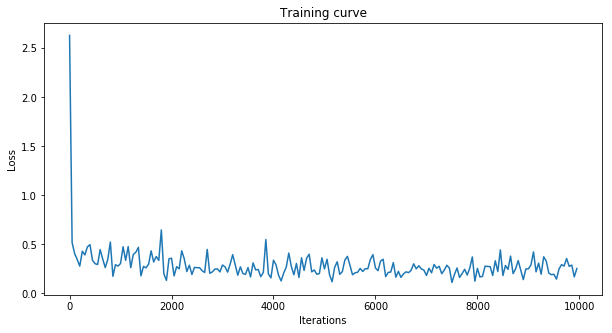

In [15]:
iterations = losses[:, 0]
train_loss = losses[:, 1]
plt.figure(figsize=(10, 5))
plt.plot(iterations, train_loss)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training curve")
plt.show()

In [17]:
example = np.array([0,1])

sample = train_set
label =train_labels_onehot

#digit = np.where(label[0]==1.0)[0][0]

feed_dict = {model.input: sample, model.ground_truth: label}
precision = model.sess.run(model.precision, feed_dict=feed_dict)
#print(np.mean(np.diag(np.matmul(prediction,label.T))))
print(precision)

0.09277246
